In [6]:
import random, numpy as np, torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModel, get_scheduler
from datasets import load_dataset
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter



In [ ]:
# ========= 1. Reproducibility =========
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
# ========= 2. Device =========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if device.type != "cuda":
    raise SystemExit("CUDA (GPU) not available.")

🖥️ Using device: cuda


In [9]:
# ========= 3. Load Dataset =========
dataset = load_dataset("dair-ai/emotion", "split")
label_list = dataset['train'].features['label'].names
num_labels = len(label_list)

train_data = list(zip(dataset['train']['text'], dataset['train']['label']))
val_data = list(zip(dataset['validation']['text'], dataset['validation']['label']))
test_data = list(zip(dataset['test']['text'], dataset['test']['label']))

C:\Users\anavn\AppData\Local\Temp\ipykernel_8260\572748038.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=values, palette="viridis")


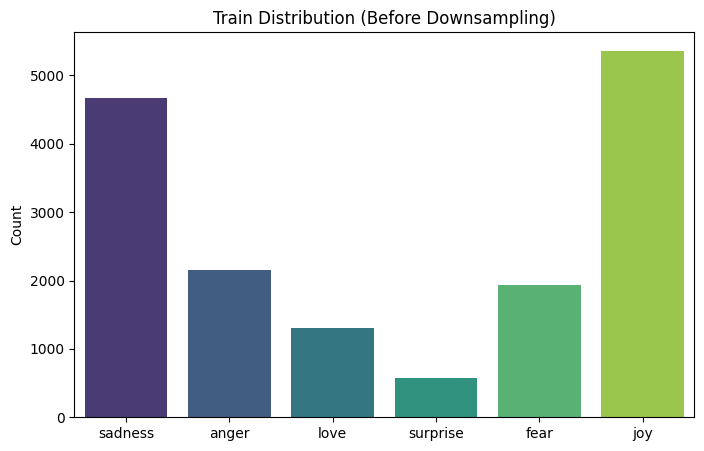

C:\Users\anavn\AppData\Local\Temp\ipykernel_8260\572748038.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=values, palette="viridis")


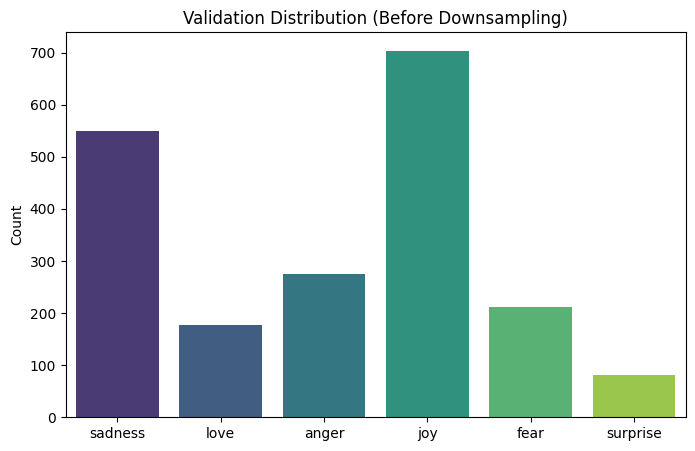

C:\Users\anavn\AppData\Local\Temp\ipykernel_8260\572748038.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=values, palette="viridis")


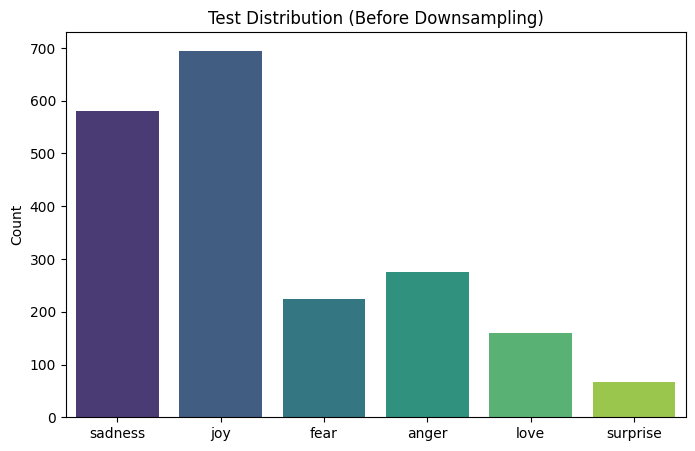

In [10]:
# ========= 4. Visualize Class Distribution =========
def plot_class_distribution(data, title):
    counts = Counter(label for _, label in data)
    labels = [label_list[i] for i in counts.keys()]
    values = list(counts.values())
    plt.figure(figsize=(8,5))
    sns.barplot(x=labels, y=values, palette="viridis")
    plt.title(title)
    plt.ylabel("Count")
    plt.show()

# Before downsampling
plot_class_distribution(train_data, "Train Distribution (Before Downsampling)")
plot_class_distribution(val_data, "Validation Distribution (Before Downsampling)")
plot_class_distribution(test_data, "Test Distribution (Before Downsampling)")

C:\Users\anavn\AppData\Local\Temp\ipykernel_8260\572748038.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=values, palette="viridis")


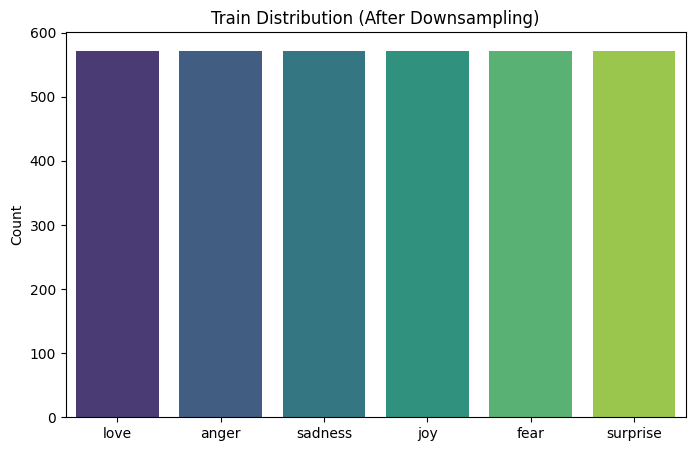

C:\Users\anavn\AppData\Local\Temp\ipykernel_8260\572748038.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=values, palette="viridis")


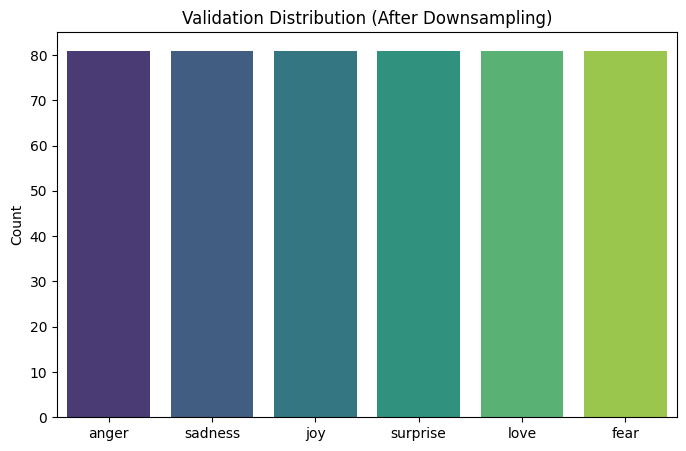

C:\Users\anavn\AppData\Local\Temp\ipykernel_8260\572748038.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=values, palette="viridis")


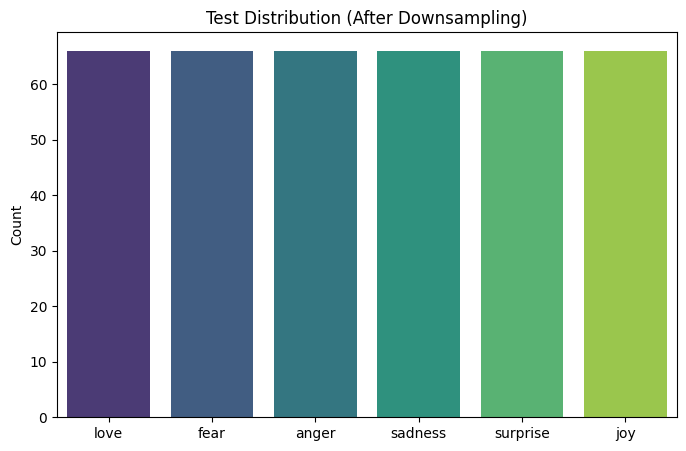

In [11]:
# ========= 5. Downsample =========
def downsample(data):
    label_groups = {}
    for text, label in data:
        label_groups.setdefault(label, []).append((text, label))
    min_size = min(len(v) for v in label_groups.values())
    balanced = []
    for samples in label_groups.values():
        balanced.extend(random.sample(samples, min_size))
    random.shuffle(balanced)
    return balanced

train_data = downsample(train_data)
val_data = downsample(val_data)
test_data = downsample(test_data)

# After downsampling
plot_class_distribution(train_data, "Train Distribution (After Downsampling)")
plot_class_distribution(val_data, "Validation Distribution (After Downsampling)")
plot_class_distribution(test_data, "Test Distribution (After Downsampling)")


In [12]:
# ========= 6. Tokenizer =========
model_name = "boltuix/bert-emotion"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(texts):
    return tokenizer(texts, padding=True, truncation=True, max_length=128)

train_texts, train_labels = zip(*train_data)
val_texts, val_labels = zip(*val_data)
test_texts, test_labels = zip(*test_data)

train_encodings = tokenize(train_texts)
val_encodings = tokenize(val_texts)
test_encodings = tokenize(test_texts)

train_labels = list(train_labels)
val_labels = list(val_labels)
test_labels = list(test_labels)

In [13]:
# ========= 7. Dataset Class =========
class EmotionDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        return {
            "input_ids": torch.tensor(self.encodings["input_ids"][idx]),
            "attention_mask": torch.tensor(self.encodings["attention_mask"][idx]),
            "labels": torch.tensor(self.labels[idx])
        }

train_dataset = EmotionDataset(train_encodings, train_labels)
val_dataset = EmotionDataset(val_encodings, val_labels)
test_dataset = EmotionDataset(test_encodings, test_labels)

In [14]:
# ========= 8. Mean Pooling =========
class MeanPooling(nn.Module):
    def forward(self, last_hidden_state, attention_mask):
        mask_exp = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * mask_exp, 1)
        sum_mask = torch.clamp(mask_exp.sum(1), min=1e-9)
        return sum_embeddings / sum_mask

In [15]:
# ========= 9. Deep LMU =========
class DeepLMU(nn.Module):
    def __init__(self, hidden_size, memory_size=128, num_layers=6):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_size, hidden_size),
                nn.GELU(),
                nn.LayerNorm(hidden_size),
                nn.Dropout(0.2),
                nn.Linear(hidden_size, memory_size),
                nn.GELU(),
                nn.LayerNorm(memory_size),
                nn.Dropout(0.2),
                nn.Linear(memory_size, hidden_size),
                nn.GELU(),
                nn.LayerNorm(hidden_size)
            ) for _ in range(num_layers)
        ])
        self.self_attention = nn.MultiheadAttention(hidden_size, num_heads=8, batch_first=True)
        self.attention_norm = nn.LayerNorm(hidden_size)
    def forward(self, x):
        for layer in self.layers:
            x = x + layer(x)
        attn_output, _ = self.self_attention(x, x, x)
        return self.attention_norm(x + attn_output)

In [16]:
# ========= 10. Model =========
class EmotionClassifier(nn.Module):
    def __init__(self, model_name, num_labels):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.lmu = DeepLMU(self.bert.config.hidden_size)
        self.pooler = MeanPooling()
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_states = self.lmu(outputs.last_hidden_state)
        pooled = self.pooler(hidden_states, attention_mask)
        return self.classifier(self.dropout(pooled))

model = EmotionClassifier(model_name, num_labels).to(device)

In [17]:
# ========= 11. Class Weights =========
class_weights = compute_class_weight("balanced", classes=np.unique(train_labels), y=train_labels)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

In [18]:
# ========= 12. Optimizer & Scheduler =========
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)
scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0,
                           num_training_steps=len(train_loader) * 20)

In [19]:
# ========= 13. Evaluation =========
def evaluate(loader):
    model.eval()
    total_loss, preds, labels = 0, [], []
    with torch.no_grad():
        for batch in loader:
            input_ids, mask, targets = batch["input_ids"].to(device), batch["attention_mask"].to(device), batch["labels"].to(device)
            output = model(input_ids, mask)
            loss = criterion(output, targets)
            total_loss += loss.item()
            preds.extend(torch.argmax(output, dim=1).cpu().numpy())
            labels.extend(targets.cpu().numpy())
    return total_loss / len(loader), accuracy_score(labels, preds), preds, labels

In [20]:
# ========= 14. Train =========
def train_model(epochs=100):
    best_acc = 0.0
    history = {"train_acc": [], "val_acc": [], "train_loss": [], "val_loss": []}
    for epoch in range(epochs):
        model.train()
        total_loss, preds_all, labels_all = 0, [], []
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            input_ids, mask, targets = batch["input_ids"].to(device), batch["attention_mask"].to(device), batch["labels"].to(device)
            optimizer.zero_grad()
            outputs = model(input_ids, mask)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            scheduler.step()
            total_loss += loss.item()
            preds_all.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            labels_all.extend(targets.cpu().numpy())
        train_acc = accuracy_score(labels_all, preds_all)
        val_loss, val_acc, _, _ = evaluate(val_loader)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)
        history["train_loss"].append(total_loss / len(train_loader))
        history["val_loss"].append(val_loss)
        print(f"Epoch {epoch+1}: Train Acc {train_acc:.4f}, Val Acc {val_acc:.4f}")
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), "main_model.pt")
    return history

history = train_model(epochs=100)

Epoch 1: 100%|██████████| 108/108 [00:06<00:00, 15.61it/s]


📊 Epoch 1: Train Acc 0.8619, Val Acc 0.9506


Epoch 2: 100%|██████████| 108/108 [00:05<00:00, 20.02it/s]


📊 Epoch 2: Train Acc 0.9432, Val Acc 0.9588


Epoch 3: 100%|██████████| 108/108 [00:05<00:00, 19.86it/s]


📊 Epoch 3: Train Acc 0.9540, Val Acc 0.9568


Epoch 4: 100%|██████████| 108/108 [00:05<00:00, 20.65it/s]


📊 Epoch 4: Train Acc 0.9580, Val Acc 0.9568


Epoch 5: 100%|██████████| 108/108 [00:05<00:00, 19.88it/s]


📊 Epoch 5: Train Acc 0.9595, Val Acc 0.9547


Epoch 6: 100%|██████████| 108/108 [00:06<00:00, 16.41it/s]


📊 Epoch 6: Train Acc 0.9665, Val Acc 0.9547


Epoch 7: 100%|██████████| 108/108 [00:09<00:00, 11.16it/s]


📊 Epoch 7: Train Acc 0.9674, Val Acc 0.9527


Epoch 8: 100%|██████████| 108/108 [00:09<00:00, 11.98it/s]


📊 Epoch 8: Train Acc 0.9706, Val Acc 0.9527


Epoch 9: 100%|██████████| 108/108 [00:09<00:00, 11.82it/s]


📊 Epoch 9: Train Acc 0.9741, Val Acc 0.9568


Epoch 10: 100%|██████████| 108/108 [00:08<00:00, 12.34it/s]


📊 Epoch 10: Train Acc 0.9752, Val Acc 0.9527


Epoch 11: 100%|██████████| 108/108 [00:09<00:00, 11.78it/s]


📊 Epoch 11: Train Acc 0.9776, Val Acc 0.9506


Epoch 12: 100%|██████████| 108/108 [00:05<00:00, 20.31it/s]


📊 Epoch 12: Train Acc 0.9776, Val Acc 0.9444


Epoch 13: 100%|██████████| 108/108 [00:05<00:00, 20.95it/s]


📊 Epoch 13: Train Acc 0.9773, Val Acc 0.9527


Epoch 14: 100%|██████████| 108/108 [00:05<00:00, 19.45it/s]


📊 Epoch 14: Train Acc 0.9781, Val Acc 0.9527


Epoch 15: 100%|██████████| 108/108 [00:05<00:00, 19.83it/s]


📊 Epoch 15: Train Acc 0.9802, Val Acc 0.9527


Epoch 16: 100%|██████████| 108/108 [00:05<00:00, 19.36it/s]


📊 Epoch 16: Train Acc 0.9819, Val Acc 0.9486


Epoch 17: 100%|██████████| 108/108 [00:07<00:00, 15.12it/s]


📊 Epoch 17: Train Acc 0.9831, Val Acc 0.9486


Epoch 18: 100%|██████████| 108/108 [00:08<00:00, 12.60it/s]


📊 Epoch 18: Train Acc 0.9822, Val Acc 0.9424


Epoch 19: 100%|██████████| 108/108 [00:08<00:00, 12.27it/s]


📊 Epoch 19: Train Acc 0.9828, Val Acc 0.9444


Epoch 20: 100%|██████████| 108/108 [00:08<00:00, 12.27it/s]


📊 Epoch 20: Train Acc 0.9843, Val Acc 0.9465


Epoch 21: 100%|██████████| 108/108 [00:08<00:00, 12.62it/s]


📊 Epoch 21: Train Acc 0.9828, Val Acc 0.9465


Epoch 22: 100%|██████████| 108/108 [00:08<00:00, 13.06it/s]


📊 Epoch 22: Train Acc 0.9843, Val Acc 0.9465


Epoch 23: 100%|██████████| 108/108 [00:07<00:00, 13.70it/s]


📊 Epoch 23: Train Acc 0.9846, Val Acc 0.9465


Epoch 24: 100%|██████████| 108/108 [00:08<00:00, 12.84it/s]


📊 Epoch 24: Train Acc 0.9831, Val Acc 0.9465


Epoch 25: 100%|██████████| 108/108 [00:08<00:00, 13.12it/s]


📊 Epoch 25: Train Acc 0.9878, Val Acc 0.9465


Epoch 26: 100%|██████████| 108/108 [00:09<00:00, 11.97it/s]


📊 Epoch 26: Train Acc 0.9848, Val Acc 0.9465


Epoch 27: 100%|██████████| 108/108 [00:09<00:00, 11.39it/s]


📊 Epoch 27: Train Acc 0.9854, Val Acc 0.9465


Epoch 28: 100%|██████████| 108/108 [00:09<00:00, 10.83it/s]


📊 Epoch 28: Train Acc 0.9860, Val Acc 0.9465


Epoch 29: 100%|██████████| 108/108 [00:09<00:00, 11.29it/s]


📊 Epoch 29: Train Acc 0.9834, Val Acc 0.9465


Epoch 30: 100%|██████████| 108/108 [00:09<00:00, 11.56it/s]


📊 Epoch 30: Train Acc 0.9846, Val Acc 0.9465


Epoch 31: 100%|██████████| 108/108 [00:09<00:00, 11.33it/s]


📊 Epoch 31: Train Acc 0.9866, Val Acc 0.9465


Epoch 32: 100%|██████████| 108/108 [00:09<00:00, 11.48it/s]


📊 Epoch 32: Train Acc 0.9843, Val Acc 0.9465


Epoch 33: 100%|██████████| 108/108 [00:09<00:00, 11.33it/s]


📊 Epoch 33: Train Acc 0.9846, Val Acc 0.9465


Epoch 34: 100%|██████████| 108/108 [00:09<00:00, 11.10it/s]


📊 Epoch 34: Train Acc 0.9831, Val Acc 0.9465


Epoch 35: 100%|██████████| 108/108 [00:09<00:00, 11.46it/s]


📊 Epoch 35: Train Acc 0.9848, Val Acc 0.9465


Epoch 36: 100%|██████████| 108/108 [00:09<00:00, 11.59it/s]


📊 Epoch 36: Train Acc 0.9848, Val Acc 0.9465


Epoch 37: 100%|██████████| 108/108 [00:09<00:00, 11.39it/s]


📊 Epoch 37: Train Acc 0.9851, Val Acc 0.9465


Epoch 38: 100%|██████████| 108/108 [00:09<00:00, 11.73it/s]


📊 Epoch 38: Train Acc 0.9822, Val Acc 0.9465


Epoch 39: 100%|██████████| 108/108 [00:09<00:00, 11.65it/s]


📊 Epoch 39: Train Acc 0.9819, Val Acc 0.9465


Epoch 40: 100%|██████████| 108/108 [00:09<00:00, 11.23it/s]


📊 Epoch 40: Train Acc 0.9834, Val Acc 0.9465


Epoch 41: 100%|██████████| 108/108 [00:09<00:00, 10.98it/s]


📊 Epoch 41: Train Acc 0.9851, Val Acc 0.9465


Epoch 42: 100%|██████████| 108/108 [00:09<00:00, 11.65it/s]


📊 Epoch 42: Train Acc 0.9872, Val Acc 0.9465


Epoch 43: 100%|██████████| 108/108 [00:09<00:00, 10.82it/s]


📊 Epoch 43: Train Acc 0.9816, Val Acc 0.9465


Epoch 44: 100%|██████████| 108/108 [00:09<00:00, 10.95it/s]


📊 Epoch 44: Train Acc 0.9857, Val Acc 0.9465


Epoch 45: 100%|██████████| 108/108 [00:09<00:00, 11.23it/s]


📊 Epoch 45: Train Acc 0.9863, Val Acc 0.9465


Epoch 46: 100%|██████████| 108/108 [00:09<00:00, 11.24it/s]


📊 Epoch 46: Train Acc 0.9851, Val Acc 0.9465


Epoch 47: 100%|██████████| 108/108 [00:09<00:00, 10.89it/s]


📊 Epoch 47: Train Acc 0.9837, Val Acc 0.9465


Epoch 48: 100%|██████████| 108/108 [00:09<00:00, 11.30it/s]


📊 Epoch 48: Train Acc 0.9878, Val Acc 0.9465


Epoch 49: 100%|██████████| 108/108 [00:09<00:00, 10.83it/s]


📊 Epoch 49: Train Acc 0.9854, Val Acc 0.9465


Epoch 50: 100%|██████████| 108/108 [00:09<00:00, 11.47it/s]


📊 Epoch 50: Train Acc 0.9840, Val Acc 0.9465


Epoch 51: 100%|██████████| 108/108 [00:09<00:00, 11.17it/s]


📊 Epoch 51: Train Acc 0.9837, Val Acc 0.9465


Epoch 52: 100%|██████████| 108/108 [00:09<00:00, 11.62it/s]


📊 Epoch 52: Train Acc 0.9866, Val Acc 0.9465


Epoch 53: 100%|██████████| 108/108 [00:09<00:00, 11.20it/s]


📊 Epoch 53: Train Acc 0.9837, Val Acc 0.9465


Epoch 54: 100%|██████████| 108/108 [00:09<00:00, 11.62it/s]


📊 Epoch 54: Train Acc 0.9848, Val Acc 0.9465


Epoch 55: 100%|██████████| 108/108 [00:09<00:00, 11.48it/s]


📊 Epoch 55: Train Acc 0.9863, Val Acc 0.9465


Epoch 56: 100%|██████████| 108/108 [00:09<00:00, 10.90it/s]


📊 Epoch 56: Train Acc 0.9857, Val Acc 0.9465


Epoch 57: 100%|██████████| 108/108 [00:09<00:00, 11.83it/s]


📊 Epoch 57: Train Acc 0.9846, Val Acc 0.9465


Epoch 58: 100%|██████████| 108/108 [00:09<00:00, 10.84it/s]


📊 Epoch 58: Train Acc 0.9846, Val Acc 0.9465


Epoch 59: 100%|██████████| 108/108 [00:07<00:00, 13.79it/s]


📊 Epoch 59: Train Acc 0.9834, Val Acc 0.9465


Epoch 60: 100%|██████████| 108/108 [00:07<00:00, 13.82it/s]


📊 Epoch 60: Train Acc 0.9851, Val Acc 0.9465


Epoch 61: 100%|██████████| 108/108 [00:07<00:00, 13.64it/s]


📊 Epoch 61: Train Acc 0.9851, Val Acc 0.9465


Epoch 62: 100%|██████████| 108/108 [00:07<00:00, 13.73it/s]


📊 Epoch 62: Train Acc 0.9878, Val Acc 0.9465


Epoch 63: 100%|██████████| 108/108 [00:07<00:00, 13.68it/s]


📊 Epoch 63: Train Acc 0.9878, Val Acc 0.9465


Epoch 64: 100%|██████████| 108/108 [00:07<00:00, 13.67it/s]


📊 Epoch 64: Train Acc 0.9811, Val Acc 0.9465


Epoch 65: 100%|██████████| 108/108 [00:07<00:00, 13.60it/s]


📊 Epoch 65: Train Acc 0.9846, Val Acc 0.9465


Epoch 66: 100%|██████████| 108/108 [00:07<00:00, 13.95it/s]


📊 Epoch 66: Train Acc 0.9840, Val Acc 0.9465


Epoch 67: 100%|██████████| 108/108 [00:07<00:00, 13.70it/s]


📊 Epoch 67: Train Acc 0.9825, Val Acc 0.9465


Epoch 68: 100%|██████████| 108/108 [00:08<00:00, 12.18it/s]


📊 Epoch 68: Train Acc 0.9854, Val Acc 0.9465


Epoch 69: 100%|██████████| 108/108 [00:09<00:00, 10.90it/s]


📊 Epoch 69: Train Acc 0.9808, Val Acc 0.9465


Epoch 70: 100%|██████████| 108/108 [00:09<00:00, 11.23it/s]


📊 Epoch 70: Train Acc 0.9857, Val Acc 0.9465


Epoch 71: 100%|██████████| 108/108 [00:09<00:00, 11.41it/s]


📊 Epoch 71: Train Acc 0.9834, Val Acc 0.9465


Epoch 72: 100%|██████████| 108/108 [00:09<00:00, 11.13it/s]


📊 Epoch 72: Train Acc 0.9854, Val Acc 0.9465


Epoch 73: 100%|██████████| 108/108 [00:09<00:00, 11.16it/s]


📊 Epoch 73: Train Acc 0.9840, Val Acc 0.9465


Epoch 74: 100%|██████████| 108/108 [00:09<00:00, 11.67it/s]


📊 Epoch 74: Train Acc 0.9828, Val Acc 0.9465


Epoch 75: 100%|██████████| 108/108 [00:09<00:00, 11.67it/s]


📊 Epoch 75: Train Acc 0.9831, Val Acc 0.9465


Epoch 76: 100%|██████████| 108/108 [00:09<00:00, 11.53it/s]


📊 Epoch 76: Train Acc 0.9860, Val Acc 0.9465


Epoch 77: 100%|██████████| 108/108 [00:09<00:00, 11.40it/s]


📊 Epoch 77: Train Acc 0.9848, Val Acc 0.9465


Epoch 78: 100%|██████████| 108/108 [00:09<00:00, 11.19it/s]


📊 Epoch 78: Train Acc 0.9837, Val Acc 0.9465


Epoch 79: 100%|██████████| 108/108 [00:09<00:00, 11.36it/s]


📊 Epoch 79: Train Acc 0.9828, Val Acc 0.9465


Epoch 80: 100%|██████████| 108/108 [00:09<00:00, 11.63it/s]


📊 Epoch 80: Train Acc 0.9819, Val Acc 0.9465


Epoch 81: 100%|██████████| 108/108 [00:09<00:00, 11.42it/s]


📊 Epoch 81: Train Acc 0.9883, Val Acc 0.9465


Epoch 82: 100%|██████████| 108/108 [00:09<00:00, 11.38it/s]


📊 Epoch 82: Train Acc 0.9863, Val Acc 0.9465


Epoch 83: 100%|██████████| 108/108 [00:09<00:00, 11.45it/s]


📊 Epoch 83: Train Acc 0.9857, Val Acc 0.9465


Epoch 84: 100%|██████████| 108/108 [00:09<00:00, 11.42it/s]


📊 Epoch 84: Train Acc 0.9831, Val Acc 0.9465


Epoch 85: 100%|██████████| 108/108 [00:10<00:00, 10.25it/s]


📊 Epoch 85: Train Acc 0.9875, Val Acc 0.9465


Epoch 86: 100%|██████████| 108/108 [00:13<00:00,  7.75it/s]


📊 Epoch 86: Train Acc 0.9857, Val Acc 0.9465


Epoch 87: 100%|██████████| 108/108 [00:14<00:00,  7.69it/s]


📊 Epoch 87: Train Acc 0.9840, Val Acc 0.9465


Epoch 88: 100%|██████████| 108/108 [00:13<00:00,  7.81it/s]


📊 Epoch 88: Train Acc 0.9851, Val Acc 0.9465


Epoch 89: 100%|██████████| 108/108 [00:14<00:00,  7.48it/s]


📊 Epoch 89: Train Acc 0.9837, Val Acc 0.9465


Epoch 90: 100%|██████████| 108/108 [00:14<00:00,  7.56it/s]


📊 Epoch 90: Train Acc 0.9866, Val Acc 0.9465


Epoch 91: 100%|██████████| 108/108 [00:14<00:00,  7.37it/s]


📊 Epoch 91: Train Acc 0.9860, Val Acc 0.9465


Epoch 92: 100%|██████████| 108/108 [00:13<00:00,  7.98it/s]


📊 Epoch 92: Train Acc 0.9831, Val Acc 0.9465


Epoch 93: 100%|██████████| 108/108 [00:13<00:00,  7.80it/s]


📊 Epoch 93: Train Acc 0.9863, Val Acc 0.9465


Epoch 94: 100%|██████████| 108/108 [00:13<00:00,  8.06it/s]


📊 Epoch 94: Train Acc 0.9857, Val Acc 0.9465


Epoch 95: 100%|██████████| 108/108 [00:13<00:00,  7.77it/s]


📊 Epoch 95: Train Acc 0.9863, Val Acc 0.9465


Epoch 96: 100%|██████████| 108/108 [00:14<00:00,  7.57it/s]


📊 Epoch 96: Train Acc 0.9819, Val Acc 0.9465


Epoch 97: 100%|██████████| 108/108 [00:13<00:00,  7.93it/s]


📊 Epoch 97: Train Acc 0.9851, Val Acc 0.9465


Epoch 98: 100%|██████████| 108/108 [00:13<00:00,  7.89it/s]


📊 Epoch 98: Train Acc 0.9863, Val Acc 0.9465


Epoch 99: 100%|██████████| 108/108 [00:13<00:00,  7.96it/s]


📊 Epoch 99: Train Acc 0.9834, Val Acc 0.9465


Epoch 100: 100%|██████████| 108/108 [00:13<00:00,  7.97it/s]


📊 Epoch 100: Train Acc 0.9846, Val Acc 0.9465


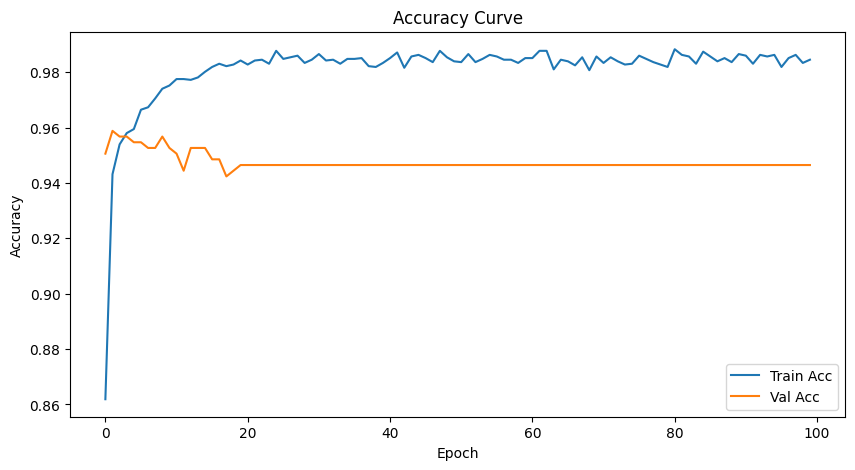

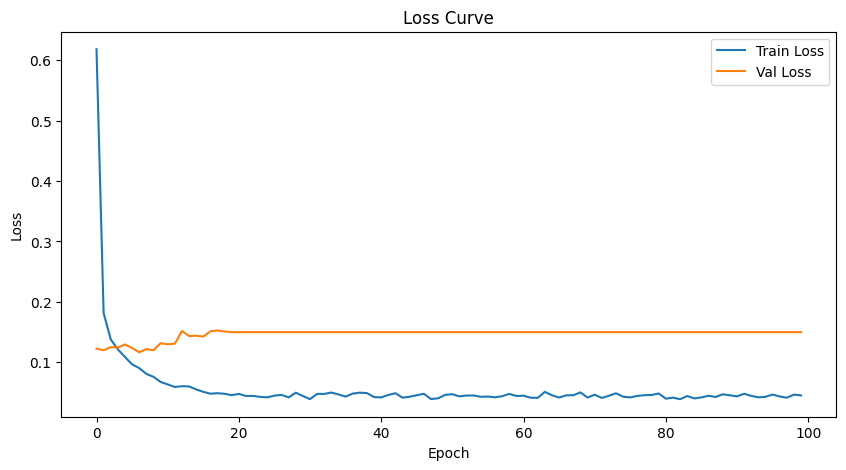

In [21]:
# ========= 15. Training Curves =========
plt.figure(figsize=(10,5))
plt.plot(history["train_acc"], label="Train Acc")
plt.plot(history["val_acc"], label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy Curve")
plt.show()

plt.figure(figsize=(10,5))
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curve")
plt.show()


🧪 Test Classification Report:
               precision    recall  f1-score   support

     sadness       1.00      0.97      0.98        66
         joy       0.97      0.92      0.95        66
        love       0.94      0.97      0.96        66
       anger       0.97      1.00      0.99        66
        fear       0.95      0.94      0.95        66
    surprise       0.94      0.97      0.96        66

    accuracy                           0.96       396
   macro avg       0.96      0.96      0.96       396
weighted avg       0.96      0.96      0.96       396



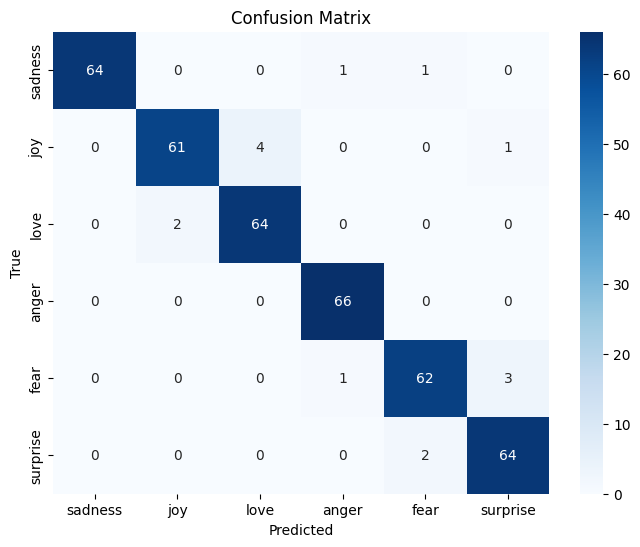

In [22]:
# ========= 16. Test Evaluation =========
model.load_state_dict(torch.load("main_model.pt"))
model.eval()
_, test_acc, preds, labels = evaluate(test_loader)
print("\n🧪 Test Classification Report:\n", classification_report(labels, preds, target_names=label_list))

cm = confusion_matrix(labels, preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_list, yticklabels=label_list)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()